Environment: tldm

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import save_image
from torchsummary import summary
import torch.nn.functional as F

/home/taha/.conda/envs/tldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, img_folder, transform=None, std=None):
        """
        Args:
            img_folder (str): Path to the folder containing images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.img_folder = img_folder
        self.transform = transform
        self.std = std
        self.img_paths = [os.path.join(img_folder, fname) for fname in os.listdir(img_folder) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)  # Read image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Convert image to float32 for safe addition
        img = img.astype(np.float32)

        # Add Gaussian noise
        noise = np.random.normal(0, self.std, img.shape).astype(np.float32)  # Mean 0, Std 20
        noisy_img = img + noise

        # Clip values to [0, 255] and convert back to uint8
        noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)

        if self.transform:
            img = self.transform(img.astype(np.uint8))  # Apply transform to original image
            noisy_img = self.transform(noisy_img)       # Apply transform to noisy image

        return img, noisy_img

In [3]:
# Define transformations (optional)
transform = transforms.Compose([
    transforms.ToPILImage(),   # Convert numpy array to PIL image [h w c]
    transforms.Resize((256, 256)),  # Resize image to 256x256
    transforms.ToTensor(),  # Convert image to Tensor [c h w]
])

In [4]:
# Load datasets
test_dataset = CustomImageDataset("/home/data/taha/UNET-denoising/celebahq_toy/test", transform=transform, std=20)

# Create DataLoaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print dataset size
print(f"Test samples: {len(test_dataset)}")

Test samples: 200


In [5]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # input: 256x256x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 254x254x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 252x252x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 126x126x64

        # input: 126x126x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 124x124x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 122x122x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 61x61x128

        # input: 61x61x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 27x27x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 25x25x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 13x13x256

        # input: 13x13x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 11x11x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 9x9x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 5x5x512

        # input: 5x5x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 3x3x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 1x1x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=3)
model = model.to(device)

# Define the path to your saved model file
model_path = '/home/data/taha/UNET-denoising/clean_task_unet_denoising/training_random_std_0_200/best_model_random_std.pth'

# Load the saved model
checkpoint = torch.load(model_path)

# Load the model's state dictionary
model.load_state_dict(checkpoint)
# summary(model, input_size=(3, 256, 256), batch_size=64)

<All keys matched successfully>

In [7]:
def calculate_psnr(img1, img2, max_val=1.0):
    mse = F.mse_loss(img1, img2)  # Mean Squared Error
    psnr_value = 10 * torch.log10(max_val**2 / mse)
    return psnr_value

In [8]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(img1, img2):
    # Convert tensors to numpy arrays
    img1_np = img1.squeeze().cpu().numpy().transpose(1, 2, 0)
    img2_np = img2.squeeze().cpu().numpy().transpose(1, 2, 0)
    ssim_value = ssim(img1_np, img2_np, channel_axis=-1, data_range=img2_np.max() - img2_np.min())
    return ssim_value


In [9]:
# Initialize list to store Denoised PSNR values
psnr_denoised_values = []

# Assuming images are scaled to [0, 1]
model.eval()
total_psnr_noisy = 0
total_ssim_noisy = 0
total_psnr_denoised = 0
total_ssim_denoised = 0

with torch.no_grad():
    for test_clean_images, test_noisy_images in test_loader:
        test_clean_images, test_noisy_images = test_clean_images.to(device), test_noisy_images.to(device)
        test_outputs = model(test_noisy_images)

        # Calculate PSNR and SSIM
        for i in range(test_clean_images.size(0)): # Iterate over the batch
            psnr_noisy = calculate_psnr(test_noisy_images[i], test_clean_images[i])
            ssim_noisy = calculate_ssim(test_noisy_images[i], test_clean_images[i])
            psnr_denoised = calculate_psnr(test_outputs[i], test_clean_images[i])
            ssim_denoised = calculate_ssim(test_outputs[i], test_clean_images[i])

            # Store denoised PSNR values
            psnr_denoised_values.append(psnr_denoised.item())

            total_psnr_noisy += psnr_noisy.item()
            total_ssim_noisy += ssim_noisy
            total_psnr_denoised += psnr_denoised.item()
            total_ssim_denoised += ssim_denoised

# Average metrics
num_images = len(test_loader.dataset)
print(f"Average PSNR (Noisy vs Clean): {total_psnr_noisy / num_images:.2f}")
print(f"Average SSIM (Noisy vs Clean): {total_ssim_noisy / num_images:.4f}")
print(f"Average PSNR (Denoised vs Clean): {total_psnr_denoised / num_images:.2f}")
print(f"Average SSIM (Denoised vs Clean): {total_ssim_denoised / num_images:.4f}")

# Save PSNR values to a file
import pandas as pd

# Get std from the dataset object
std_value = test_dataset.std  # Access the std value used in the dataset

# Save as CSV for violin plot
psnr_df = pd.DataFrame({'std': [std_value] * len(psnr_denoised_values), 'psnr_denoised': psnr_denoised_values})
psnr_df.to_csv('denoised_psnr_values.csv', index=False)

print(f"Denoised PSNR values saved to 'denoised_psnr_values.csv' with std={std_value}")

Average PSNR (Noisy vs Clean): 22.52
Average SSIM (Noisy vs Clean): 0.4066
Average PSNR (Denoised vs Clean): 32.41
Average SSIM (Denoised vs Clean): 0.8923
Denoised PSNR values saved to 'denoised_psnr_values.csv' with std=20


In [10]:
sampled_test_noisy_image = test_noisy_images[0:1,:,:,:]
sampled_test_clean = test_clean_images[0:1,:,:,:]
sampled_test_output = test_outputs[0:1:,:,:,:]   

save_image(sampled_test_noisy_image, 'testnoisyimagebeforeunet.jpg')
save_image(sampled_test_clean, 'testtargetcleanimage.jpg')
save_image(sampled_test_output, 'testcleanimageafterunet.jpg')

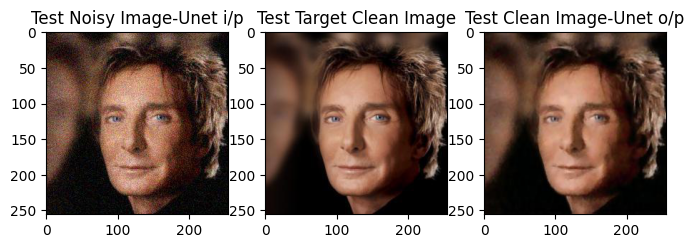

In [11]:
plt.figure(figsize=(8,8))
img1 = mpimg.imread("/home/data/taha/UNET-denoising/clean_task_unet_denoising/testing_random_std_0_200_toy/testnoisyimagebeforeunet.jpg")
img2 = mpimg.imread("/home/data/taha/UNET-denoising/clean_task_unet_denoising/testing_random_std_0_200_toy/testtargetcleanimage.jpg")
img3 = mpimg.imread("/home/data/taha/UNET-denoising/clean_task_unet_denoising/testing_random_std_0_200_toy/testcleanimageafterunet.jpg")
plt.subplot(1,3,1).set_title("Test Noisy Image-Unet i/p")
plt.imshow(img1)
plt.subplot(1,3,2).set_title("Test Target Clean Image")
plt.imshow(img2)
plt.subplot(1,3,3).set_title("Test Clean Image-Unet o/p")
plt.imshow(img3)
plt.show()